In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr
import sys

cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

import fit_polynomial_methods as fit
import data_organize as dorg

In [2]:
# Adjust parameters here to customize run

### CONSTANTS ####
c = 2.99792458e8                      # [m/s] Speed of light
dt = 25e-12                   # [s] TCSPC resolution

### PARAMETERS ###
window_bnd = [30e-9, 33e-9]       # [s] Set boundaries for binning to exclude outliers
exclude_shots = True                     # Set TRUE to exclude data to work with smaller dataset
set_max_det = False
max_lsr_shot = 10000
max_lsr_shot_ref = 100500                   # Include up to certain number of laser shots
deadtime = 25e-9                  # [s] Acquisition deadtime

# Make sure file location is accurate
cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_11.10.35.ARSENL.OD10.ARSENL.nc'
fname_ref = r'/Dev_0_-_2022-04-15_11.17.49.ARSENL.OD20.ARSENL.nc'

In [3]:
flight_time, n_shots, t_det_lst = dorg.data_organize(dt, data_dir, fname, window_bnd, max_lsr_shot, set_max_det, exclude_shots)
flight_time_ref, n_shots_ref, t_det_lst_ref = dorg.data_organize(dt, data_dir, fname_ref, window_bnd, max_lsr_shot_ref, set_max_det, exclude_shots)

Last sync event doesn't correspond to a detection event. Choosing nearest corresponding sync event (index: 10001)...


In [4]:
print('\n{}:'.format(fname[36:40]))
print('Number of detections: {}'.format(len(flight_time)))
print('Number of laser shots: {}'.format(n_shots))
print('\n{}:'.format(fname_ref[36:40]))
print('Number of detections: {}'.format(len(flight_time_ref)))
print('Number of laser shots: {}'.format(n_shots_ref))


OD10:
Number of detections: 4728
Number of laser shots: 10001

OD20:
Number of detections: 4490
Number of laser shots: 100500


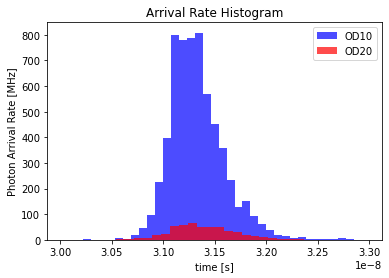

In [5]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bin_edges = np.histogram(flight_time, bins=34)
binwidth = np.diff(bin_edges)[0]
N = n / binwidth / n_shots  # [Hz] Scale counts to arrival rate
center = (bin_edges[:-1]+bin_edges[1:]) / 2
ax.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.7, label=fname[36:40])
n, bin_edges = np.histogram(flight_time_ref, bins=34)
binwidth = np.diff(bin_edges)[0]
N = n / binwidth / n_shots_ref  # [Hz] Scale counts to arrival rate
center = (bin_edges[:-1]+bin_edges[1:]) / 2
ax.bar(center, N/1e6, align='center', width=binwidth, color='r', alpha=0.7, label=fname_ref[36:40])
ax.set_title('Arrival Rate Histogram')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
ax.legend()
plt.show()

## Now applying the curve_fit routine to my data. Code designed after Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to N-order exponentiated polynomial.

In [5]:
# Generate fit and validation sets

t_phot_fit_tnsr, t_phot_val_tnsr, t_phot_eval_tnsr, n_shots_fit, n_shots_val, n_shots_eval = fit.generate_fit_val_eval(flight_time, flight_time_ref, n_shots, n_shots_ref)


In [6]:
# optimization parameters

rel_step_lim = 1e-8  # termination criteria based on step size
max_epochs = 400     # maximum number of iterations/epochs
learning_rate = 1e-1  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations
intgrl_N = 10000        # Set number of steps in numerical integration

In [7]:
# I define the max/min times as fixed values. They are the upper/lower bounds of the fit.
# Time vector per shot
t_min = window_bnd[0]
t_max = window_bnd[1]
dt = dt
t_fine = np.arange(t_min, t_max, dt)

In [8]:
# Set iterate to True if you want to iterate through increasing complexity. 
# Otherwise set to False if you want to check a single polynomial order.
single_step_iter = False
M_max = 21  # Max polynomial complexity to test if iterating
M_lst = np.arange(6, 11, 1)

# Set True to include deadtime in noise model
include_deadtime = True

In [9]:
# Generate "active-ratio histogram" that adjusts the histogram proportionally according to how many bins the detector was "active vs dead"
active_ratio_hst = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst)
if not include_deadtime:
    active_ratio_hst = torch.ones(len(active_ratio_hst))    
    
active_ratio_hst_ref = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst_ref)
if not include_deadtime:
    active_ratio_hst_ref = torch.ones(len(active_ratio_hst))    
    

Time elapsed:

Order=6: 0.62 sec
Order=7: 0.55 sec
Order=8: 0.56 sec
Order=9: 0.67 sec
Order=10: 0.61 sec


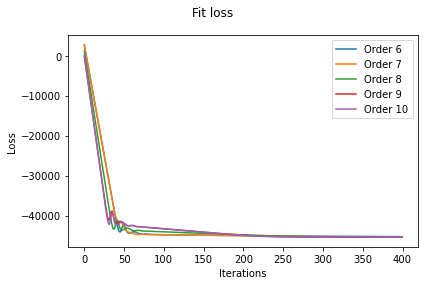

In [10]:
if single_step_iter:
    M_lst = np.arange(1, M_max, 1)
else:
    M_lst = M_lst
    M_max = max(M_lst)

iter_len = len(M_lst)
fig = plt.figure()
val_loss_arr = np.zeros(M_max+1)
eval_loss_arr = np.zeros(M_max+1)
coeffs = np.zeros((M_max+1, M_max+1))
fit_rate_fine = np.zeros((M_max+1, len(t_fine)))
print('Time elapsed:\n')

# Iterate through increasing polynomial complexity. 
# Compare fit w/ validation set and use minimum loss find optimal polynomial order.
for i in range(len(M_lst)):    
    # initialize for fit loop
    M = M_lst[i]  # Polynomial order  (e.g., x^2 --> M=2)
    fit_model = fit.Fit_Pulse(M, t_min, t_max)
    optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
    epoch = 0
    rel_step = 1e3*rel_step_lim
    fit_loss_lst = []
    val_loss_lst = []
    rel_step_lst = []

    init_C = np.zeros(M+1)
    for j in range(M+1):
        init_C[j] = fit_model.C[j].item()

    # set the loss function to use a Poisson point process likelihood function
    loss_fn = fit.pois_loss

    # perform fit
    start = time.time()
    t_fit_norm = fit_model.tstamp_condition(t_phot_fit_tnsr, t_min, t_max)
    t_val_norm = fit_model.tstamp_condition(t_phot_val_tnsr, t_min, t_max)
    t_eval_norm = fit_model.tstamp_condition(t_phot_eval_tnsr, t_min, t_max)
    t_intgrl = fit.cheby_poly(torch.linspace(0, 1, intgrl_N), M)
    while rel_step > rel_step_lim and epoch < max_epochs:
        fit_model.train()
        pred_fit, integral_fit = fit_model(intgrl_N, active_ratio_hst, t_fit_norm, t_intgrl, cheby=True)
        loss_fit = loss_fn(pred_fit, integral_fit*n_shots_fit)  # add regularization here
        fit_loss_lst += [loss_fit.item()]

        # calculate relative step as an average over the last term_persist iterations
        if epoch == 0:
            rel_step_lst+=[1e3*rel_step_lim]
            rel_step = 1e3*rel_step_lim
        else:
            rel_step_lst+=[(fit_loss_lst[-2]-fit_loss_lst[-1])/np.abs(fit_loss_lst[-2])]
            rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

        # update estimated parameters
        loss_fit.backward()
        optimizer.step()

        # zero out the gradient for the next step
        optimizer.zero_grad()

        epoch+=1

    pred_mod_seg, __ = fit_model(intgrl_N, active_ratio_hst, torch.tensor(t_fine), t_intgrl, cheby=False)
    fit_rate_fine[M, :] = pred_mod_seg.detach().numpy().T
    coeffs[M, 0:M+1] = fit_model.C.detach().numpy().T
    
    # Calculate validation loss
    # Using fit generated from fit set, calculate loss when applied to validation set
    pred_val, integral_val = fit_model(intgrl_N, active_ratio_hst, t_val_norm, t_intgrl, cheby=True)
    loss_val = loss_fn(pred_val, integral_val*n_shots_fit)
    val_loss_arr[M] = loss_val
    
    # Now use the generated fit and validate against evaluation set (e.g., no deadtime, high-OD data)
    pred_eval, integral_eval = fit_model(intgrl_N, active_ratio_hst_ref, t_eval_norm, t_intgrl, cheby=True)

    # If the number of shots between evaluation set and validation set differ, then arrival rate needs to be scaled accordingly. 
    n_det_eval = len(pred_eval)
    C_scale = n_det_eval / n_shots_eval / integral_eval
    loss_eval = loss_fn(C_scale*pred_eval, C_scale*integral_eval*n_shots_eval)
    eval_loss_arr[M] = loss_eval
        
    end = time.time()
    print('Order={}: {:.2f} sec'.format(M, end-start))
    
    plt.plot(fit_loss_lst, label='Order {}'.format(M))

plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.suptitle('Fit loss')
plt.tight_layout()
plt.legend()
plt.show()

#### Some definitions:
Test data: Fit set. Typically the first half of the data.

Validation data: Typically the second half of the data. An independent set that can be used to calculation "validation loss."

Evaluation data: High fidelity data. Typically a reference set with data unaffected by deadtime, e.g., high OD dataset.

In [12]:
print('Validation loss for\n')
for i in range(len(M_lst)):
    print('Order {}: {:.5f}'.format(M_lst[i], val_loss_arr[M_lst[i]]))

Validation loss for

Order 6: -45219.84110
Order 7: -45339.39919
Order 8: -45398.21166
Order 9: -45375.14867
Order 10: -45378.06973


In [13]:
print('Evaluation loss for\n')
for i in range(len(M_lst)):
    print('Order {}: {:.5f}'.format(M_lst[i], eval_loss_arr[M_lst[i]]))

Evaluation loss for

Order 6: -72519.71808
Order 7: -72928.55481
Order 8: -73141.70564
Order 9: -73049.24843
Order 10: -73013.28849


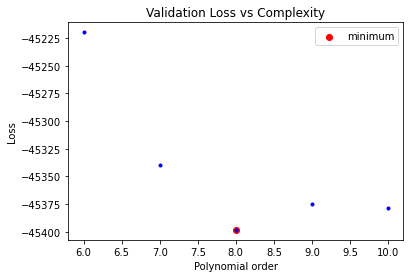

In [14]:
minx, miny = np.argmin(val_loss_arr), min(val_loss_arr)

plt.plot(M_lst, val_loss_arr[M_lst], 'b.')
plt.scatter(minx, miny,c='r', label='minimum')
plt.title('Validation Loss vs Complexity')
plt.ylabel('Loss')
plt.xlabel('Polynomial order')
plt.legend()
plt.show()

In [15]:
# Choose order to investigate
order = 8
try:
    model = coeffs[order, 0:order+1]
    for i in range(order+1):
        print('Final C{}: {:.4f}'.format(i, model[i]))
except:
    print("\nERROR: Order exceeds maximum complexity iteration value.\n")

Final C0: 5.4623
Final C1: 5.8872
Final C2: -6.0416
Final C3: -6.0691
Final C4: -6.7861
Final C5: 1.3752
Final C6: 0.3857
Final C7: -3.0915
Final C8: -0.1498


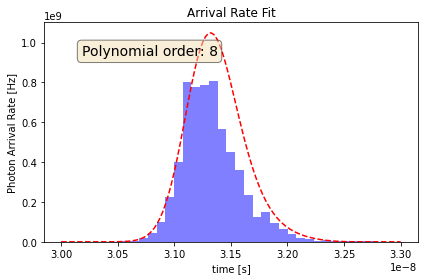

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

n, bins = np.histogram(flight_time, bins=34)
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
t_fine = np.arange(t_min, t_max, dt)
fit_rate_seg = fit_rate_fine[order, :]
ax.plot(t_fine, fit_rate_seg, 'r--')
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [s]')
ax.set_ylabel('Photon Arrival Rate [Hz]')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.1, 0.90, 'Polynomial order: {}'.format(order), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()


# Graveyard

In [4]:
# Rescaling factor optimization routine
# def loss_lse(f1, f2):
#     return 0.5*(f1 - f2)**2

# def C_optimize(loss1, loss_fn, ratio_lim=0.99999999999, max_epochs=10000):
#     epoch = 0
#     alpha = 0.00000000001
#     C = 1
#     ratio_step = 0
#     while ratio_step<=ratio_lim and epoch<max_epochs:
#         n_det_eval = len(pred_eval)
#         loss2 = loss_fn(C*pred_eval, C*integral_eval*n_shots_eval)
#         cost = loss_lse(loss1, loss2)
#         step = -2*(loss1-loss2)*(n_shots_eval*integral_eval - n_det_eval/C)
#         C = C - alpha*step

#         cost_lst.append(cost.item())
#         C_lst.append(C.item())

#         if epoch!=0:
#             ratio_step = C_lst[-1]/C_lst[-2]

#         epoch += 1

#     return C
